# Motion

Motion analysis is one of the key techniques for various video recognition problems such as action recognition. In this section we will learn two representative methods for computing optical flows: motion vectors between two images.

In [2]:
from skvideo.io import vread
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

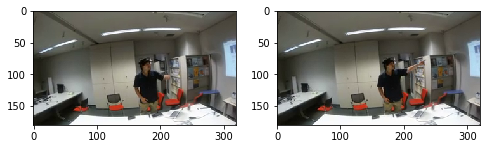

In [7]:
video = vread('data/yks_cvpr2016_sub/pointing/00001_s.mp4')
img1 = video[40]
img2 = video[50]
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)

## Computing Optical Flows

In the two example images shown above you can see the person moving his hand to point somewhere. The first method, `cv2.calcOpticalFlowFarneback`, compute an optical flow for each pixel. The output of this method will be a map with two channels: horizontal and vertical displacements.

CPU times: user 16.8 ms, sys: 1.56 ms, total: 18.3 ms
Wall time: 16.9 ms
output shape: (180, 320, 2)


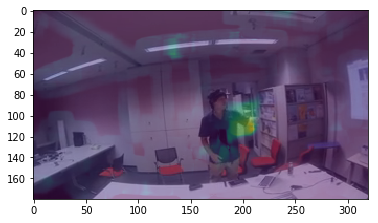

In [36]:
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)  # inputs of the optical flow computation needs to be grayscale.
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
%time flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
# calcOpticalFlowFarneback has many hyperparameters, but you can use opencv defaults shown above.
print('output shape:', flow.shape)
amp = np.linalg.norm(flow, axis=2)  # computing motion amplitudes
plt.imshow(img1)
plt.imshow(amp, alpha=.5)

You may want to save time by not computing optical flows for all pixels. `cv2.calcOpticalFlowPyrLK` can compute *sparse* optical flows on several selected points. The key to compute sparse optical flows is how to define such points. For instance, `cv2.goodFeaturesToTrack` gives us some *corner* points that are likely to have complex textures around. Alternatively, you can define grid points using `np.meshgrid`.

CPU times: user 3.13 ms, sys: 200 µs, total: 3.33 ms
Wall time: 1.77 ms


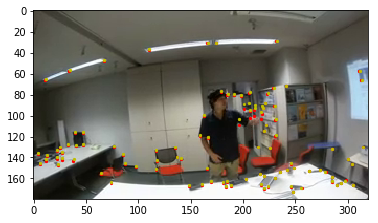

In [37]:
pts = cv2.goodFeaturesToTrack(img1_gray, 100, 1e-3, 4).squeeze()
%time pts_new = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, pts, None)[0]
# sparse optical flows method gives as output the *destination* of each input point.
plt.imshow(img1)
plt.scatter(pts[:, 0], pts[:, 1], 5, 'r')
plt.scatter(pts_new[:, 0], pts_new[:, 1], 5, 'y')

CPU times: user 2.5 ms, sys: 1.35 ms, total: 3.84 ms
Wall time: 2.31 ms


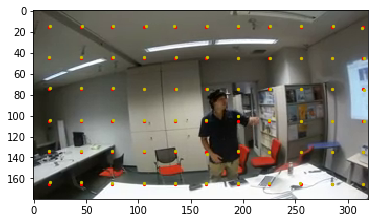

In [38]:
x, y = np.meshgrid(np.arange(15, 320, 30), np.arange(15, 180, 30))
pts = np.vstack((x.flatten(), y.flatten())).T.astype('float32')
%time pts_new = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, pts, None)[0]
plt.imshow(img1)
plt.scatter(pts[:, 0], pts[:, 1], 5, 'r')
plt.scatter(pts_new[:, 0], pts_new[:, 1], 5, 'y')

In [26]:

def compute_mean_flow(video):
    
    T = len(video)
    mean_flow = np.zeros((T, 2))
    for t in range(T):
        img1 = video[np.max((0, t - 1))]
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        img2 = video[t]
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

        flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mean_flow[t] = flow.mean(axis=(0, 1))
    return mean_flow

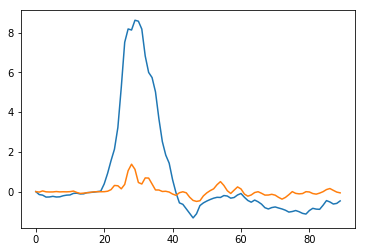

In [188]:
mean_flow = compute_mean_flow(video)
plt.plot(mean_flow)

In [3]:
from keras.applications.resnet50 import ResNet50
model = ResNet50()

102858752/102853048 [==============================] - 60s 1us/step


In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
25636712 * 4

102546848